__Part 3 ‑ Predictive modeling__

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. <br>
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? <br>
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. <br>
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

__1. Perform Cleaning, EDA and Visualizations__

In [1]:
import pandas as pd
import numpy as np
import timestring
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


# disable warnings
import warnings
warnings.filterwarnings('ignore')

# converting JSON file into dataframe
with open('ultimate_data_challenge.json') as file:
    data = json.load(file)
    
df = pd.DataFrame(data)
df.dropna(inplace=True)

# updating categorical columns with get_dummies
df = pd.get_dummies(df, columns=['city', 'phone'])

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0


In [2]:
# using the max last_trip_date as the date of when data was pulled
print('Data collected on:', df.last_trip_date.max())
date_collected = df.last_trip_date.max()
date_collected = timestring.Date(date_collected)


# cut off date for retained classification is 30 days prior
retained_date = date_collected - 30*24*60*60
print('Retained cut off date:',retained_date)

Data collected on: 2014-07-01
Retained cut off date: 2014-06-01 00:00:00


In [3]:
# adding retained column that indicates whether customer was retained
df['retained'] = df['last_trip_date'].apply(lambda x: x > retained_date)
df.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1,True
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0,False
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1,False
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1,True
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0,False


In [4]:
# data of retained customers
df[df.retained == True].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
count,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000,16608.000000
mean,4.914539,4.759387,4.593497,1.072629,9.109694,3.617654,62.385814,0.219412,0.342425,0.438162,0.158538,0.841462
std,4.135179,0.293452,0.538174,0.142464,14.045947,5.164414,27.251023,0.413861,0.474535,0.496176,0.365256,0.365256
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.570000,4.600000,4.300000,1.000000,0.000000,0.000000,46.700000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.680000,4.800000,4.800000,1.010000,2.700000,2.000000,64.700000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.650000,5.000000,5.000000,1.100000,14.300000,5.000000,83.300000,0.000000,1.000000,1.000000,0.000000,1.000000
max,79.340000,5.000000,5.000000,4.500000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# data of lost customers
df[df.retained == False].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
count,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000,24837.000000
mean,5.824816,4.787853,4.607219,1.074619,8.757628,1.935661,60.498675,0.397190,0.124331,0.478480,0.380883,0.619117
std,5.692917,0.463974,0.663079,0.228783,20.693270,2.920521,39.044695,0.489326,0.329965,0.499547,0.485614,0.485614
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.310000,4.800000,4.300000,1.000000,0.000000,0.000000,28.600000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.890000,5.000000,5.000000,1.000000,0.000000,1.000000,66.700000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.240000,5.000000,5.000000,1.000000,0.000000,2.000000,100.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,79.690000,5.000000,5.000000,8.000000,100.000000,73.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


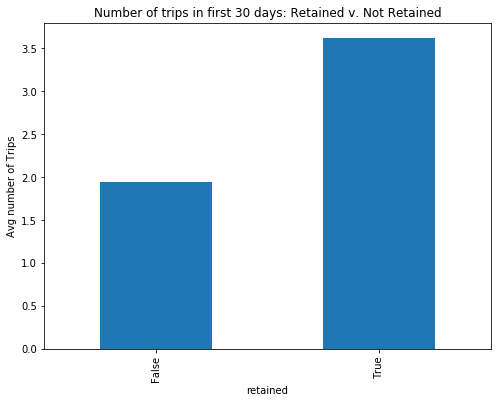

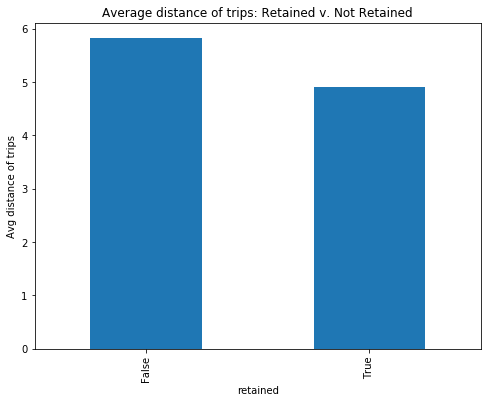

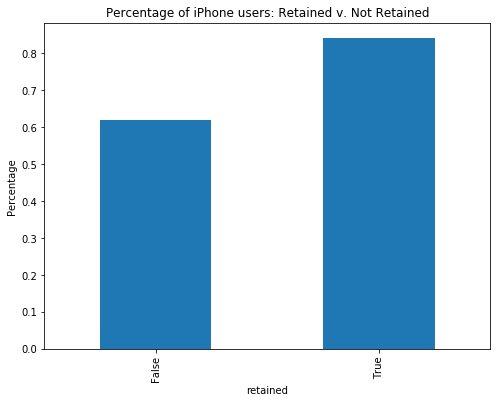

In [6]:
grouped_df = df.groupby('retained').mean()

plt.figure(figsize=(8, 6))
grouped_df['trips_in_first_30_days'].plot(kind='bar')
plt.title('Number of trips in first 30 days: Retained v. Not Retained')
plt.ylabel('Avg number of Trips')
plt.show()

plt.figure(figsize=(8, 6))
grouped_df['avg_dist'].plot(kind='bar')
plt.title('Average distance of trips: Retained v. Not Retained')
plt.ylabel('Avg distance of trips')
plt.show()

plt.figure(figsize=(8, 6))
grouped_df['phone_iPhone'].plot(kind='bar')
plt.title('Percentage of iPhone users: Retained v. Not Retained')
plt.ylabel('Percentage')
plt.show()

In [7]:
print('{} of the customers were retained.'.format(round(len(df[df.retained == False]) / len(df),4)))

0.5993 of the customers were retained.


__2. Build Predictive Model__

In [8]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,0,1,0,0,1,True
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,1,0,0,1,0,False
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,1,0,0,0,1,False
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,0,1,0,0,1,True
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,1,0,False


In [9]:
# normalizing numeric data
numeric_feats_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
df_feats_to_norm = pd.DataFrame(df, columns=numeric_feats_list)
df_feats_no_norm = df.drop(columns = numeric_feats_list)

min_max_scaler = preprocessing.MinMaxScaler()
normalized_numeric_feats = min_max_scaler.fit_transform(df_feats_to_norm)
normalized_numeric_feats = pd.DataFrame(normalized_numeric_feats, columns=numeric_feats_list, index=df_feats_to_norm.index)

normalized_df = pd.concat([normalized_numeric_feats, df_feats_no_norm], axis=1)
normalized_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,last_trip_date,signup_date,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
0,0.046053,1.000,0.925,0.014286,0.154,0.032,0.462,2014-06-17,2014-01-25,True,0,1,0,0,1,True
1,0.103652,1.000,1.000,0.000000,0.000,0.000,0.500,2014-05-05,2014-01-29,False,1,0,0,1,0,False
2,0.009662,1.000,0.825,0.000000,0.000,0.024,1.000,2014-01-07,2014-01-06,False,1,0,0,0,1,False
3,0.029615,0.975,0.900,0.020000,0.200,0.072,0.800,2014-06-29,2014-01-10,True,0,1,0,0,1,True
4,0.039277,0.975,0.850,0.027143,0.118,0.112,0.824,2014-03-15,2014-01-27,False,0,0,1,1,0,False


In [10]:
# splitting data into training and test sets
X = normalized_df.drop(['retained', 'last_trip_date', 'signup_date'], axis=1).values
y = normalized_df['retained'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
%%time
# KNN classifier

knn_param_grid = {'n_neighbors': np.arange(1, 10)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_param_grid, cv=5)
knn_cv.fit(X_train, y_train)
knn_cv_y_pred = knn_cv.predict(X_test)

print('k-NN best n_neighbors:', knn_cv.best_params_, '\n')
print('k-NN test set confusion matrix:')
print(confusion_matrix(y_test, knn_cv_y_pred), '\n')
print('k-NN test set classification report:')
print(classification_report(y_test, knn_cv_y_pred))

k-NN best n_neighbors: {'n_neighbors': 9} 

k-NN test set confusion matrix:
[[4001 1003]
 [1110 2175]] 

k-NN test set classification report:
              precision    recall  f1-score   support

       False       0.78      0.80      0.79      5004
        True       0.68      0.66      0.67      3285

   micro avg       0.75      0.75      0.75      8289
   macro avg       0.73      0.73      0.73      8289
weighted avg       0.74      0.75      0.74      8289

CPU times: user 2min 50s, sys: 1.12 s, total: 2min 51s
Wall time: 2min 57s


In [13]:
%%time
# Random Forest classifier

rf_param_grid = {'n_estimators': np.arange(10, 100, 10), 
                 'max_depth': np.arange(10, 50, 10),
                 'bootstrap': [True, False]}

rf = RandomForestClassifier()
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, cv=5)
rf_random_grid.fit(X_train, y_train)
rf_y_pred = rf_random_grid.predict(X_test)

print('Tuned Random Forest Params:', rf_random_grid.best_params_, '\n')

print('Tuned Random Forest test set confusion matrix:')
print(confusion_matrix(y_test, rf_y_pred), '\n')
print('Tuned Random Forest test set classification report:')
print(classification_report(y_test, rf_y_pred), '\n')

Tuned Random Forest Params: {'n_estimators': 50, 'max_depth': 10, 'bootstrap': True} 

Tuned Random Forest test set confusion matrix:
[[4187  817]
 [1030 2255]] 

Tuned Random Forest test set classification report:
              precision    recall  f1-score   support

       False       0.80      0.84      0.82      5004
        True       0.73      0.69      0.71      3285

   micro avg       0.78      0.78      0.78      8289
   macro avg       0.77      0.76      0.76      8289
weighted avg       0.78      0.78      0.78      8289
 

CPU times: user 1min 32s, sys: 2.58 s, total: 1min 34s
Wall time: 1min 37s


In [14]:
%%time
# Logistic Regression 

lr_param_grid = {'C': np.arange(.5, 5, .5)}

logreg = LogisticRegression()   # Ridge
logreg_cv = GridSearchCV(logreg, lr_param_grid, cv=5)
logreg_cv.fit(X_train, y_train)
logreg_cv_pred = logreg_cv.predict(X_test)

print('Log Reg best C value', logreg_cv.best_params_, '\n')

print('Log Reg test set confusion matrix:')
print(confusion_matrix(y_test, logreg_cv_pred), '\n')
print('Log Reg test set classification report:')
print(classification_report(y_test, logreg_cv_pred))

Log Reg best C value {'C': 4.0} 

Log Reg test set confusion matrix:
[[4129  875]
 [1496 1789]] 

Log Reg test set classification report:
              precision    recall  f1-score   support

       False       0.73      0.83      0.78      5004
        True       0.67      0.54      0.60      3285

   micro avg       0.71      0.71      0.71      8289
   macro avg       0.70      0.68      0.69      8289
weighted avg       0.71      0.71      0.71      8289

CPU times: user 12.6 s, sys: 836 ms, total: 13.4 s
Wall time: 8.92 s


Given that Ulimate would be most concerned about identifying non-retained customers, I would use the recall of non-retained customers as the basis for measuring performance.  Of the three algorithms used, Random Forests generated the best recall score for non-retained customers.  It also outperformed both Logistic Regression and KNN in F1 score and precision for classifying both non-retained and retained customers.

__3. Insights and Recommendations__

From analyzing the data, we obtain several insights:

1. Astapor has the highest percentage of customers that were not retained.  I would recommend Ultimate to solicit customer feedback from Astapor riders to determine why there is a high turnover rate in the city.  
2. Although it was not collected, it may be beneficial to collect age of the customers.  Different age groups have different user behaviors and they may be able to provide services/promotions to specific demographics to increase retention rate.
3. It appears that retained customers took nearly twice as many trips in their first 30 days as non-retained customers.  It might be beneficial to introduce some promotions early in a customers first month to see if they can familiarize themselves with the service.